In [1]:
import torch
import torch.nn as nn
import math

# Model

In [2]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model:int, vocabulary_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocabulary_size
        self.embedding = nn.Embedding(vocabulary_size, d_model)
    def forward(self,x):
        return self.embedding(x) * math.sqrt(self.d_model)


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, sequence_len:int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = sequence_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(sequence_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, sequence_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)
    def forward(self,x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

In [4]:
class LayerNormalization(nn.Module):

    def __init__(self, parameters_shape: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(parameters_shape)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(parameters_shape)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [5]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)

        return x


In [6]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

In [7]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            x = self.norm(x)
            x = self.dropout(sublayer(x)) + x
            return x + self.dropout(sublayer(self.norm(x)))

In [8]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [9]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


In [10]:
class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [11]:
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)


In [12]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)

In [13]:

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)
    

In [14]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N_layers: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N_layers):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N_layers):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer

# Train

In [15]:
# from model import build_transformer
# from dataset import BilingualDataset, causal_mask
# from config import get_config, get_weights_file_path

# import torchtext.datasets as datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR

import warnings
from tqdm import tqdm
import os
from pathlib import Path

# Huggingface datasets and tokenizers
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from torch.utils.tensorboard import SummaryWriter

import wandb

import torchmetrics

c:\Users\kainak0\Documents\gitProjects\mia\MIA-203_redes_neuronales\final\translatepy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
ds_raw = load_dataset(f"somosnlp-hackathon-2022/spanish-to-quechua", split='train')
    

In [17]:
ds_raw

Dataset({
    features: ['es', 'qu'],
    num_rows: 102747
})

In [18]:
def get_config():
    return {
        "batch_size": 56,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 200,
        "d_model": 512,
        'N_layers': 4,
        'heads': 8,
        'dropout': 0.1,
        'ffn_hidden': 2048,
        "datasource": 'spanish-to-quechua',
        "lang_src": "es",
        "lang_tgt": "qu",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

In [19]:
config = get_config()

In [20]:
# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])


In [21]:
def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
def hist_len_sentence(ds_raw, lang, min_sentence_len, max_sentence_len):
    len_sentence = [len(x) for x in ds_raw[lang]]
    len_sentence_ranged = [x for x in len_sentence if min_sentence_len < x < max_sentence_len]

    # Generate sample data
    data = np.array(len_sentence_ranged)

    # Create the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot histogram
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Customize the plot
    plt.title('Normal Distribution Histogram', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(0, max_sentence_len, 20))
    # Add some padding to the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

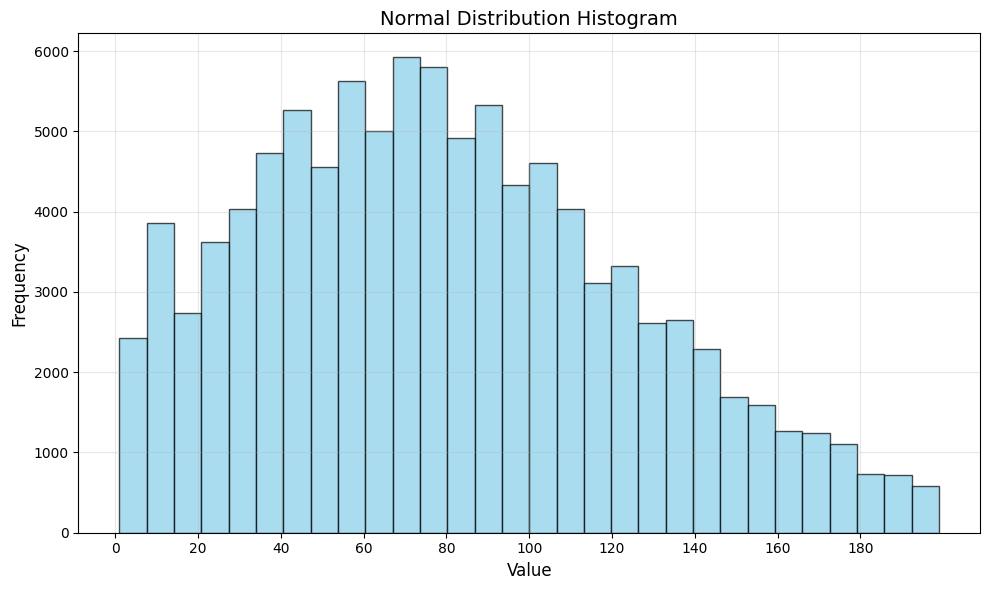

In [23]:
hist_len_sentence(ds_raw, lang = config['lang_src'], min_sentence_len = 0, max_sentence_len = 200)

In [24]:
def filter_by_length(dataset, min_len=1, max_len=1000):
    def length_filter(example):
        # Check length for all string/list features
        for key, value in example.items():
            if isinstance(value, (str, list)):
                if len(value) < min_len or len(value) > max_len:
                    return False
        return True
    
    filtered_dataset = dataset.filter(length_filter)
    return filtered_dataset

# Usage example:
filtered_ds_raw = filter_by_length(ds_raw, min_len=20, max_len=200)

In [25]:
filtered_ds_raw

Dataset({
    features: ['es', 'qu'],
    num_rows: 89047
})

In [26]:
def get_all_sentences(ds, lang):
    for item in ds:
        yield item[lang]

In [27]:
def get_or_build_tokenizer(ds, lang):
    tokenizer_path = Path("tokenizer_{0}.json".format(lang))
    # if not Path.exists(tokenizer_path):
    if True:
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer


In [28]:
from torch.utils.data import Dataset

class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")
        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )
        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )
        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )
        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }
    
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

In [29]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

In [30]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)
            
            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break
    
    if writer:
        # Evaluate the character error rate
        # Compute the char error rate 
        metric = torchmetrics.CharErrorRate()
        cer = metric(predicted, expected)
        writer.add_scalar('validation cer', cer, global_step)
        writer.flush()

        # Compute the word error rate
        metric = torchmetrics.WordErrorRate()
        wer = metric(predicted, expected)
        writer.add_scalar('validation wer', wer, global_step)
        writer.flush()

        # Compute the BLEU metric
        metric = torchmetrics.BLEUScore()
        bleu = metric(predicted, expected)
        writer.add_scalar('validation BLEU', bleu, global_step)
        writer.flush()

In [31]:
tokenizer_tgt = get_or_build_tokenizer( filtered_ds_raw, config['lang_tgt'])
tokenizer_src =  get_or_build_tokenizer( filtered_ds_raw, config['lang_src'])

In [32]:
train_ds_size = int(0.9 * len(filtered_ds_raw))
val_ds_size = len(filtered_ds_raw) - train_ds_size
train_ds_raw, val_ds_raw = random_split(filtered_ds_raw, [train_ds_size, val_ds_size])


In [33]:
train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, src_lang = config['lang_src'],tgt_lang = config['lang_tgt'], seq_len = 200)
val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, src_lang = config['lang_src'],tgt_lang = config['lang_tgt'], seq_len = 200)


In [34]:
train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)


In [35]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'],
        N_layers=config['N_layers'], h = config['heads'], dropout = config['dropout'], d_ff = config['ffn_hidden'])
    return model

In [36]:
def train_model(config,train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt ):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    else:
        print("plz bu a gpu :)")
     
    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
    # if False:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config,train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt)

Using device: cuda
Device name: NVIDIA GeForce RTX 3090
Device memory: 23.99951171875 GB
No model to preload, starting from scratch


Processing Epoch 00: 100%|██████████| 1432/1432 [12:06<00:00,  1.97it/s, loss=7.201]


--------------------------------------------------------------------------------
    SOURCE: Él ve nuestras cualidades, así como vio las cualidades de los cuatro reyes de Judá.
    TARGET: Payqa chay tawa kamachiqkunapa imayna kasqankuta qawasqanman hinam, ñuqanchikpa imayna kasqanchiktapas qawanqa.
 PREDICTED: 
--------------------------------------------------------------------------------
    SOURCE: La mayoría de los adultos necesitan ocho horas de sueño por noche para recuperarse física, emocional y mentalmente.
    TARGET: Yuyayniyoq runakunaqa yaqa llapankum 8 horata sapa tuta puñunanku, chaymi yanapanqa cuerponkupi chaynataq piensayninkupi allinlla tarikunankupaq.
 PREDICTED: 
--------------------------------------------------------------------------------


Processing Epoch 01:  50%|█████     | 720/1432 [06:05<05:59,  1.98it/s, loss=7.209]